# Shakhnazar Kapar, Murat Almas, Aniyar Baibossyn
Final project - "Skin cancer detection"

In [1]:
import os
import numpy as np
import tensorflow as tf
import shutil
import pandas as pd
import seaborn as sb
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import load_model
from google.colab import files



# Connecting to google drive(We used Almas's google drive).
We uploaded dataset to google drive for convenience.
Actual dataset link where we get dataset is  = `https://universe.roboflow.com/redronin/preprocessing-and-augmentations-zl5il/model/11`


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the paths to the training, validation, and testing directories


In [3]:
train_dir = '/content/drive/MyDrive/skin cancer dataset/train'
valid_dir = '/content/drive/MyDrive/skin cancer dataset/valid'
test_dir = '/content/drive/MyDrive/skin cancer dataset/test'

In [4]:
# Get the class names
class_names = os.listdir(train_dir)

# print list class names
print("Classes in the dataset:")
print(class_names)

Classes in the dataset:
['malignant', 'benign']


In [5]:
# show paths images in the train class
imagepaths = list(glob(train_dir + "/**/*.*"))
print(imagepaths)

['/content/drive/MyDrive/skin cancer dataset/train/malignant/1028_jpg.rf.86fc1ae5b047dc72894254be54b4b97a.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1019_jpg.rf.843014adaa28610d6bfdf33d73d3af10.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1017_jpg.rf.4866f288b0c5ee64f3e66013bf44b81c.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1002_jpg.rf.1c390169f9457035dc6ff47b8c47c723.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1015_jpg.rf.708bf0e2ec6b26e97ce3c7edbe7213ed.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1011_jpg.rf.a59ed1c7e35f6fd1d83165ee9a3e8b64.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1001_jpg.rf.3a1e65f79bdf41fe76cde5373c72002a.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1026_jpg.rf.3492c06625ad24449870e9f425bac6f4.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1001_jpg.rf.940316f89e749b645a1f86f8ff92dec4.jpg', 

# What contain our dataset?

In [6]:
# Initialize a dictionary to store the image counts for each class
class_image_counts = {}

for class_label in class_names:
    class_dir_train = os.path.join(train_dir, class_label)
    class_dir_valid = os.path.join(valid_dir, class_label)
    class_dir_test = os.path.join(test_dir, class_label)

    num_images_train = len(os.listdir(class_dir_train))
    num_images_valid = len(os.listdir(class_dir_valid))
    num_images_test = len(os.listdir(class_dir_test))

    total_images = num_images_train + num_images_valid + num_images_test

    class_image_counts[class_label] = total_images
for class_label, count in class_image_counts.items():
    print(f"Class: {class_label}, have images: {count}")

# Calculate the overall number of images in the dataset
overall_images = sum(class_image_counts.values())
print("Overall images in the dataset:", overall_images)

Class: malignant, have images: 1345
Class: benign, have images: 1348
Overall images in the dataset: 2693


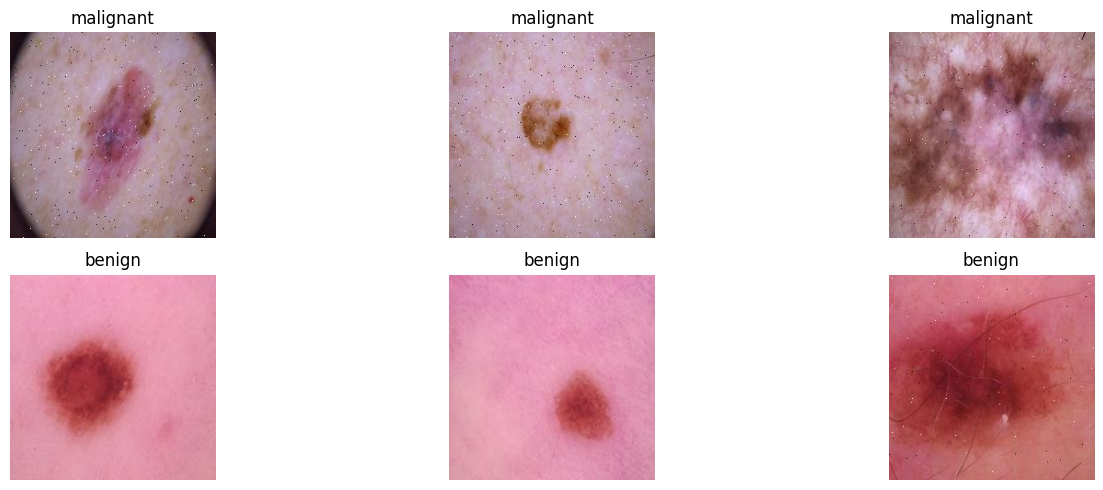

In [7]:

def show_sample_images(data_dir, class_names, num_samples=3):
    plt.figure(figsize=(15, 5))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)

        sample_images = random.sample(image_files, min(num_samples, len(image_files)))

        for j, image_file in enumerate(sample_images):
            image_path = os.path.join(class_dir, image_file)
            img = Image.open(image_path)

            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display sample images
show_sample_images(train_dir, class_names)


In [8]:
# Create a DataFrame to store image paths and labels
def create_dataframe(data_dir):
    image_paths = []
    labels = []
    class_names = os.listdir(data_dir)

    for class_label in class_names:
        class_dir = os.path.join(data_dir, class_label)
        image_files = os.listdir(class_dir)
        image_paths.extend([os.path.join(class_dir, img) for img in image_files])
        labels.extend([class_label] * len(image_files))

    return pd.DataFrame({'ImagePath': image_paths, 'Label': labels})

# Create DataFrames for each dataset
train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)


print(train_df.head())
print("\n")
print(train_df.tail())

print("\n\n\n")

print(valid_df.head())
print("\n")
print(valid_df.tail())

print("\n\n\n")

print(test_df.head())
print("\n")
print(test_df.tail())


                                           ImagePath      Label
0  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
1  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
2  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
3  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
4  /content/drive/MyDrive/skin cancer dataset/tra...  malignant


                                              ImagePath   Label
1795  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1796  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1797  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1798  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1799  /content/drive/MyDrive/skin cancer dataset/tra...  benign




                                           ImagePath   Label
0  /content/drive/MyDrive/skin cancer dataset/val...  benign
1  /content/drive/MyDrive/skin cancer dataset/val...  benign
2  /content/drive/MyDrive/skin cancer datas

<Figure size 800x600 with 0 Axes>

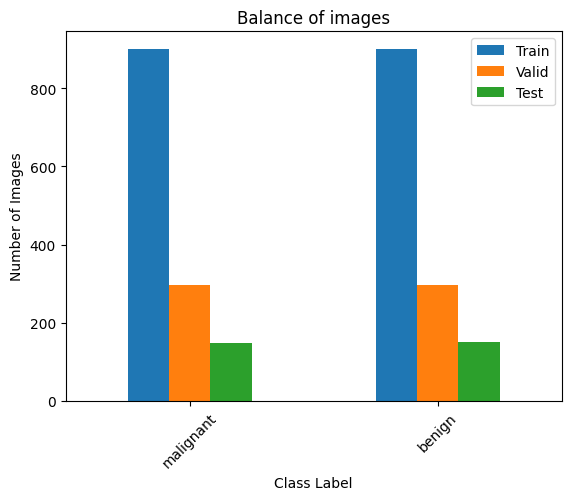

Train Dataset:
malignant    900
benign       900
Name: Label, dtype: int64

Validation Dataset:
benign       298
malignant    297
Name: Label, dtype: int64

Test Dataset:
benign       150
malignant    148
Name: Label, dtype: int64


In [9]:
# Get the counts for each class in each dataset
train_counts = train_df['Label'].value_counts()
valid_counts = valid_df['Label'].value_counts()
test_counts = test_df['Label'].value_counts()

class_counts = pd.concat([train_counts, valid_counts, test_counts], axis=1, keys=['Train', 'Valid', 'Test'])

# Plot the balance of images
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Balance of images')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

print("Train Dataset:")
print(train_counts)
print("\nValidation Dataset:")
print(valid_counts)
print("\nTest Dataset:")
print(test_counts)


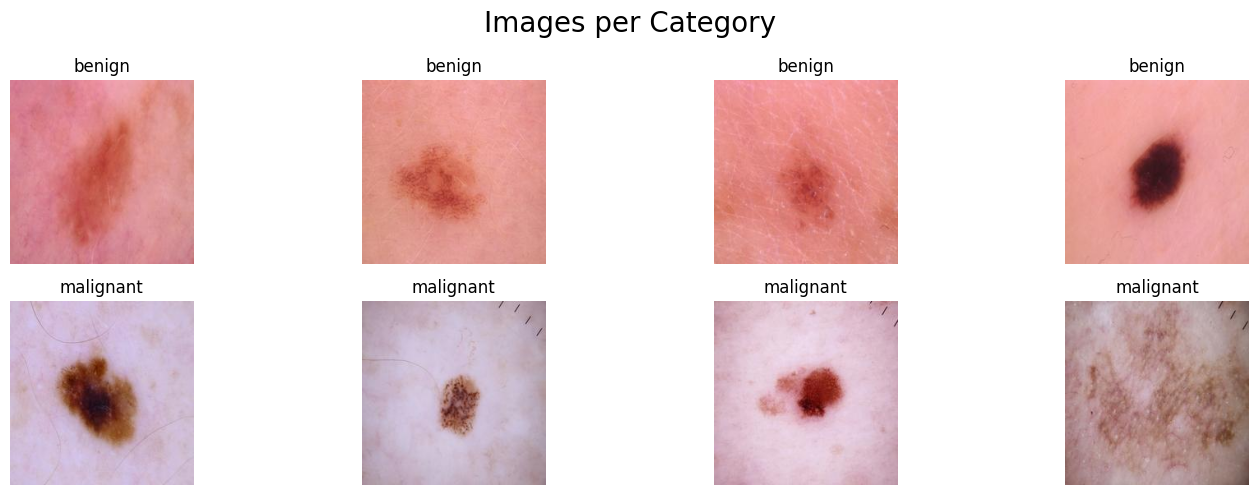

In [10]:
def show_images_per_category(df, num_images=4, figsize=(15, 5)):
    categories = df['Label'].unique()
    num_categories = len(categories)

    fig, ax = plt.subplots(num_categories, num_images, figsize=figsize)
    fig.suptitle('Images per Category', fontsize=20)

    for i, cat in enumerate(categories):
        indices = df[df['Label'] == cat].index
        num_indices = len(indices)

        random_indices = random.sample(indices.tolist(), min(num_images, num_indices)) if num_indices > 0 else [None] * num_images

        for j, idx in enumerate(random_indices):
            if idx is not None:
                img_path = df.loc[idx, 'ImagePath']
                img = np.array(Image.open(img_path))
                ax[i, j].imshow(img)
                ax[i, j].set_title(f'{cat}')
            else:
                ax[i, j].axis('off')
                ax[i, j].text(0.5, 0.5, f"No images found for {cat}", horizontalalignment='center', verticalalignment='center', fontsize=12)

            ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

show_images_per_category(test_df)


# Main part goes here!
Data preprocessing and augmentation


In [11]:
# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Create data generators


In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 1800 images belonging to 2 classes.
Found 595 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


# Build the model


In [13]:
# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

# Fitting, Evaluating, Plotting the model

In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
56/56 [==============================] - 813s 14s/step - loss: 0.6589 - accuracy: 0.6058 - val_loss: 0.5980 - val_accuracy: 0.7135
Epoch 2/10
56/56 [==============================] - 227s 4s/step - loss: 0.5444 - accuracy: 0.7274 - val_loss: 0.6205 - val_accuracy: 0.7431
Epoch 3/10
56/56 [==============================] - 223s 4s/step - loss: 0.4770 - accuracy: 0.7698 - val_loss: 0.5786 - val_accuracy: 0.7292
Epoch 4/10
56/56 [==============================] - 247s 4s/step - loss: 0.4950 - accuracy: 0.7511 - val_loss: 0.5386 - val_accuracy: 0.7500
Epoch 5/10
56/56 [==============================] - 242s 4s/step - loss: 0.4456 - accuracy: 0.7794 - val_loss: 0.5917 - val_accuracy: 0.6753
Epoch 6/10
56/56 [==============================] - 222s 4s/step - loss: 0.4267 - accuracy: 0.7902 - val_loss: 0.5870 - val_accuracy: 0.7465
Epoch 7/10
56/56 [==============================] - 220s 4s/step - loss: 0.4380 - accuracy: 0.7941 - val_loss: 0.6012 - val_accuracy: 0.6580
Epoch 8/10
5

# Plot training history


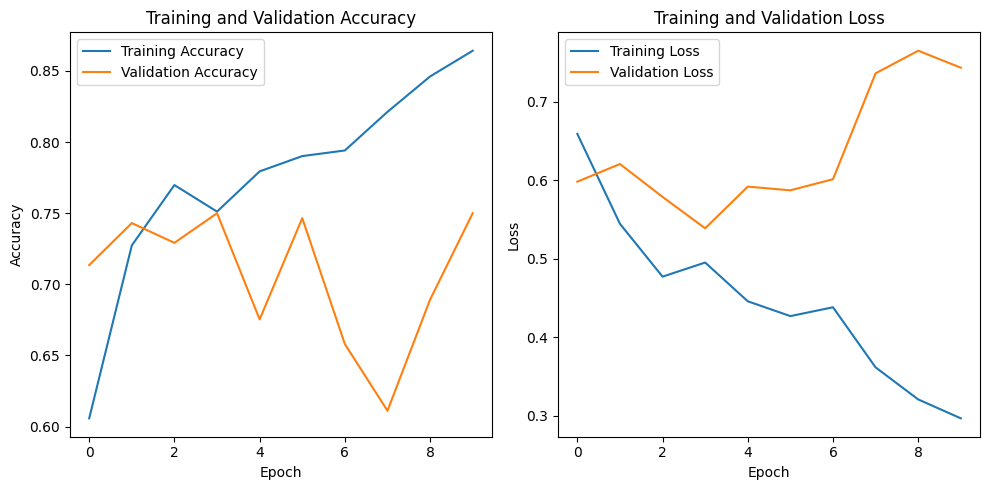

In [15]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Interesting numbers


298/298 [==============================] - 17s 56ms/step - loss: 0.6212 - accuracy: 0.7383
Test Loss: 0.6211907267570496
Test Accuracy: 0.7382550239562988
298/298 [==============================] - 11s 37ms/step

Additional Metrics:
Classification Report:
              precision    recall  f1-score   support

      benign       0.80      0.65      0.71       150
   malignant       0.70      0.83      0.76       148

    accuracy                           0.74       298
   macro avg       0.75      0.74      0.74       298
weighted avg       0.75      0.74      0.74       298



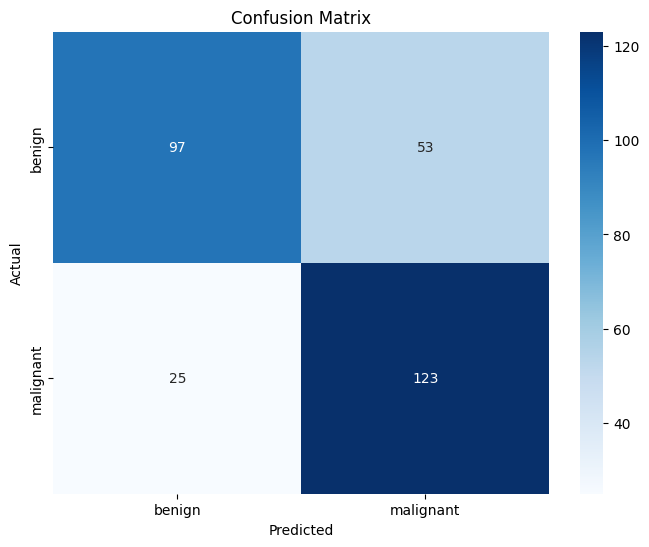

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict on test data
predictions = model.predict(test_generator)
predicted_classes = np.round(predictions).flatten()

print("\nAdditional Metrics:")
print("Classification Report:")
print(classification_report(test_generator.classes, predicted_classes, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, predicted_classes)
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Real predictiong some images


In [18]:
model.save('/content/drive/MyDrive/skin cancer dataset/cancerDetectionModel.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [73]:
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    return img_array

In [87]:
def predict_uploaded_image(model, image_path):
    img = preprocess_image(image_path)

    prediction = model.predict(np.expand_dims(img, axis=0))

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    if prediction[0][0] >= 0.5:
        print("Predicted class: Malignant")
        print("Confidence (Malignant):", "{:.5f}".format(prediction[0][0]))
        print("Confidence (Benign):", "{:.5f}".format(1 - prediction[0][0]))
    else:
        print("Predicted class: Benign")
        print("Confidence (Benign):", "{:.5f}".format(prediction[0][0]))
        print("Confidence (Malignant):", "{:.5f}".format(1 - prediction[0][0]))

Saving 124_jpg.rf.cc86f2fe0d660d3de409596e0a25fd92.jpg to 124_jpg.rf.cc86f2fe0d660d3de409596e0a25fd92.jpg
1/1 [==============================] - 0s 446ms/step


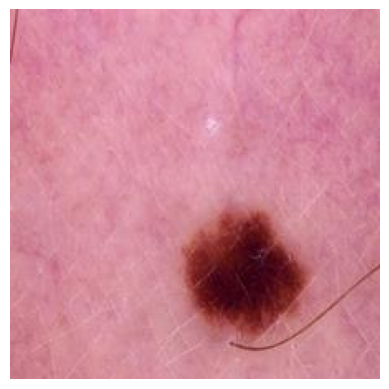

Predicted class: Benign
Confidence (Benign): 0.46557
Confidence (Malignant): 0.53443


In [89]:
upload_button = files.upload()
uploaded_image_path = list(upload_button.keys())[0]

predict_uploaded_image(model, uploaded_image_path)